In [1]:
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display
import soundfile as sf
import matplotlib.patches as patch
import matplotlib.pyplot as plt
import IPython.display as ipd
from pathlib import Path
from tqdm.notebook import tqdm
from scipy.io import wavfile
import time
import os
import shutil
from skimage import io
from skimage.color import rgb2gray,rgba2rgb
#https://github.com/iver56/audiomentations ?
%matplotlib inline
CC_ROOT=Path("D:\\KidElectric\\rfcx_kaggle") #Cookiecutter datascience-style project
CC_DATA_OUT=CC_ROOT.joinpath('data').joinpath('interim')

DATA_ROOT = CC_ROOT.joinpath('data')
TRAIN_AUDIO_ROOT = DATA_ROOT.joinpath('raw').joinpath('train')#Update to point to cookiecutter data/raw/train
TEST_AUDIO_ROOT = DATA_ROOT.joinpath('raw').joinpath('test')#Update to point to cookiecutter data/raw/test


df_train = pd.DataFrame({
    "recording_id": [path.stem for path in TRAIN_AUDIO_ROOT.glob("*.flac")],
})

df_test = pd.DataFrame({
    "recording_id": [path.stem for path in TEST_AUDIO_ROOT.glob("*.flac")],
})

df_tp=pd.read_csv(CC_ROOT.joinpath('references').joinpath('train_tp.csv')).set_index('recording_id')

df_fp=pd.read_csv(CC_ROOT.joinpath('references').joinpath('train_fp.csv')).set_index('recording_id')


In [2]:
class params:
    """
    Parameters used for generating spectrograms from audio data
    """
    sr = 48000 #sampling rate

    # Melspectrogram
    n_mels = 128
    fmin = 80
    fmax = 14000  
    n_fft=2048
    hop_length = 512
    


def has_tp_fp(rec,df_tp,df_fp):
    #Many recordings have both tp and fp data labeled.
    has_tp=False
    has_fp=False
    if rec in df_tp.index:
        has_tp = True
    if rec in df_fp.index:
        has_fp = True
    return has_tp, has_fp

def clip_info(rec,df):
    keep={'species_id':[],'t_min':[],'t_max':[]}
    for key in df.keys():
        if key in keep.keys():
            if isinstance(df[key][rec],pd.core.series.Series):
                keep[key]=[val for val in df[key][rec].values]
            else:
                keep[key].append(df[key][rec])
    return keep

def clip_identity(rec,df_tp,df_fp,start,stop):
    out={'tp_spec':[],'tp':0,
         'fp_spec':[],'fp':0}
    has_fp=False
    has_tp=False
    if rec in df_tp.index:
        info = clip_info(rec,df_tp)
        for i,spec in enumerate(info['species_id']):
            t_min=info['t_min'][i]
            t_max=info['t_max'][i]
            overlap=(t_min < stop and t_min >= start) or (t_max >= start and t_max < stop)
            if overlap == True:
                has_tp=True
                out['tp_spec'].append(spec)
                out['tp']+=1
    
    if rec in df_fp.index:
        info = clip_info(rec,df_fp)
        for i,spec in enumerate(info['species_id']):
            t_min=info['t_min'][i]
            t_max=info['t_max'][i]
            overlap=(t_min < stop and t_min >= start) or (t_max >= start and t_max < stop)
            if overlap == True:
                has_fp=True
                out['fp_spec'].append(spec + 24)
                out['fp']+=1   
    return out


        


In [42]:
#1) Remove any TP clips where true positive species audio probably too short ( < 0.5 seconds)
# (Except if species == 14, because this species often truly is less than 0.5s.)
params.clip_dur=6 # second chunks
params.min_dur=0.5 #seconds
resume=0
use_df=df_train
use_root=TRAIN_AUDIO_ROOT
params.dest=DATA_ROOT.joinpath('interim').joinpath('train').joinpath('clip_decomp').joinpath('too_short')
params.use_root=use_root

if params.dest.exists() == False:
    os.mkdir(params.dest)
imgs=[png for png in params.dest.parent.glob('TP*.png')]
for ii,fn in enumerate(imgs):
    img=fn.parts[-1]
    spec=img.split('_')[1]
    if spec != '14': #All true clip durs < 0.5s are species 14
        rec=img.split('_')[2]
        rec_part=img.split('_')[3].split('.')[0]
        clip_start=float(rec_part)*params.clip_dur
        clip_stop= clip_start + params.clip_dur
        info = clip_info(rec,df_tp)
        for i,s in enumerate(info['species_id']):
            if s == int(spec):
                t_min=info['t_min'][i]
                t_max=info['t_max'][i]
                if (t_max > clip_start) and (t_min < clip_stop):
                    #This call is within this clip.
                    if ((t_max - clip_start) < params.min_dur) or ((clip_stop - t_min) < params.min_dur):
                        #But only the very end or beginning of the call is in the clip
                        shutil.move(str(fn),str(params.dest)) #Move to a separate folder
                        print('%d) %s is %1.3f s == too short!' % (ii,img,np.min([(clip_stop - t_min),(t_max - clip_start)])))


4) TP_0_067f49f8b_9.png is 0.091 s == too short!
7) TP_0_157a50231_5.png is 0.213 s == too short!
9) TP_0_251737ef0_5.png is 0.069 s == too short!
33) TP_0_97630c03d_1.png is 0.133 s == too short!
39) TP_0_a54894b33_4.png is 0.219 s == too short!
49) TP_0_e25933b0a_2.png is 0.368 s == too short!
50) TP_0_e25933b0a_3.png is 0.427 s == too short!
52) TP_0_f5e6456f0_6.png is 0.331 s == too short!
53) TP_0_f5e6456f0_7.png is 0.464 s == too short!
59) TP_10_055d22517_7.png is 0.416 s == too short!
86) TP_10_7764cbbfd_0.png is 0.288 s == too short!
90) TP_10_7ab084435_3.png is 0.262 s == too short!
108) TP_10_d5163b4ef_0.png is 0.445 s == too short!
113) TP_10_db34c4a5d_5.png is 0.436 s == too short!
115) TP_10_dfa6a4a64_2.png is 0.260 s == too short!
123) TP_10_f5c3420f6_5.png is 0.447 s == too short!
125) TP_11_0275e127d_1.png is 0.001 s == too short!
128) TP_11_0295e3234_1.png is 0.298 s == too short!
135) TP_11_215bb7a8d_7.png is 0.138 s == too short!
140) TP_11_373f470c4_0.png is 0.253 

In [ ]:
#Remove clips if more than one TP species is present?

Text(0.5, 1.0, 'Min spec: 33')

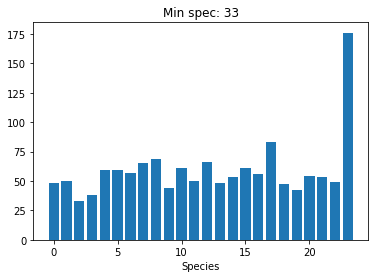

In [3]:
#How many examples of each TP are there?
src=params.dest=DATA_ROOT.joinpath('interim').joinpath('train').joinpath('clip_decomp')
imgs=[png for png in src.glob('TP*.png')]
counts=np.zeros((24,))
for ii,fn in enumerate(imgs):
    img=fn.parts[-1]
    spec=img.split('_')[1]
    counts[int(spec)] += 1
    
# print(counts)
plt.bar(x=range(0,24,1),height=counts);
plt.xlabel('Species');
plt.title('Min spec: %d' % np.min(counts))

In [6]:
# 2) Create 50 folders of downsampled clips such that:
# a) There are 15 examples of each TP species, 15 FP, 15 NP (Method 1)

src = DATA_ROOT.joinpath('interim').joinpath('train').joinpath('clip_decomp')
fp_img=[png for png in src.glob('FP*.png')]
np_img=[png for png in src.glob('NP*.png')]

num_spec = 24 #Number of unique species
nf = 50 # Number of folders
rs = 33 # Resampled number

root_dest=DATA_ROOT.joinpath('processed').joinpath('resamp_%d' % rs)
include_fp=False
include_np=False
for i in range(nf):
    dest=root_dest.joinpath(str(i))
    if dest.exists() == False:
        os.makedirs(dest)
    print('Copying to folder %d.' % i)
    if include_fp == True:
        #Resample and move FP:
        fp_rs=np.random.choice(fp_img,size=rs*2,replace=False)
        for fn in fp_rs:
            p=fn.parts[-1].split('.')[0]
            pp=p.split('_')
            newfn=''
            for x in range(len(pp)):
                if x==1:
                    newfn=newfn + '_' + '99'
                else:
                    newfn=newfn + '_' + pp[x]
            newfn=newfn[1:] + '.png'
            print('\t%s' % newfn)
            shutil.copy(fn,dest.joinpath(newfn))
    
    if include_np == True:
        # Resample and move NP:
        np_rs=np.random.choice(np_img,size=rs*4,replace=False)
        print('\t Copying %d NP...' % rs*4)
        for fn in np_rs:        
            shutil.copy(fn,dest)
        
    print('\t Copying %d of each TP...' % rs)
    for ii in range(num_spec):
        print('\t\t%d...' % ii)
        tp_img=[png for png in src.glob('TP_%d_*.png' % ii)]
        tp_rs= np.random.choice(tp_img,size=rs,replace=False)
        for fn in tp_rs:        
            shutil.copy(fn,dest)

Copying to folder 0.
	 Copying 33 of each TP...
		0...
		1...
		2...
		3...
		4...
		5...
		6...
		7...
		8...
		9...
		10...
		11...
		12...
		13...
		14...
		15...
		16...
		17...
		18...
		19...
		20...
		21...
		22...
		23...
Copying to folder 1.
	 Copying 33 of each TP...
		0...
		1...
		2...
		3...
		4...
		5...
		6...
		7...
		8...
		9...
		10...
		11...
		12...
		13...
		14...
		15...
		16...
		17...
		18...
		19...
		20...
		21...
		22...
		23...
Copying to folder 2.
	 Copying 33 of each TP...
		0...
		1...
		2...
		3...
		4...
		5...
		6...
		7...
		8...
		9...
		10...
		11...
		12...
		13...
		14...
		15...
		16...
		17...
		18...
		19...
		20...
		21...
		22...
		23...
Copying to folder 3.
	 Copying 33 of each TP...
		0...
		1...
		2...
		3...
		4...
		5...
		6...
		7...
		8...
		9...
		10...
		11...
		12...
		13...
		14...
		15...
		16...
		17...
		18...
		19...
		20...
		21...
		22...
		23...
Copying to folder 4.
	 Copying 33 of each TP...
		0...
		1...
		2...
		3...
		4.

		11...
		12...
		13...
		14...
		15...
		16...
		17...
		18...
		19...
		20...
		21...
		22...
		23...
Copying to folder 36.
	 Copying 33 of each TP...
		0...
		1...
		2...
		3...
		4...
		5...
		6...
		7...
		8...
		9...
		10...
		11...
		12...
		13...
		14...
		15...
		16...
		17...
		18...
		19...
		20...
		21...
		22...
		23...
Copying to folder 37.
	 Copying 33 of each TP...
		0...
		1...
		2...
		3...
		4...
		5...
		6...
		7...
		8...
		9...
		10...
		11...
		12...
		13...
		14...
		15...
		16...
		17...
		18...
		19...
		20...
		21...
		22...
		23...
Copying to folder 38.
	 Copying 33 of each TP...
		0...
		1...
		2...
		3...
		4...
		5...
		6...
		7...
		8...
		9...
		10...
		11...
		12...
		13...
		14...
		15...
		16...
		17...
		18...
		19...
		20...
		21...
		22...
		23...
Copying to folder 39.
	 Copying 33 of each TP...
		0...
		1...
		2...
		3...
		4...
		5...
		6...
		7...
		8...
		9...
		10...
		11...
		12...
		13...
		14...
		15...
		16...
		17...
		18...
		19...
		20

In [29]:
# 3) Create 10 folders of downsampled clips such that:
# a) There are 1000 examples of TP/FP species, 1000 examples of NP (method 2 signal vs noise model)

src = DATA_ROOT.joinpath('interim').joinpath('train').joinpath('clip_decomp')
fp_img=[png for png in src.glob('FP*.png')]
tp_img=[png for png in src.glob('TP*.png')]
allp_img=fp_img
for fn in tp_img:
    allp_img.append(fn)
    
np_img=[png for png in src.glob('NP*.png')]

num_spec = 2 #Number of unique species
nf = 10 # Number of folders
rs = 1000 # Resampled number

root_dest=DATA_ROOT.joinpath('processed').joinpath('resamp_%d' % rs)
for i in range(nf):
    dest=root_dest.joinpath(str(i))
    if dest.exists() == False:
        os.makedirs(dest)
    print('Copying to folder %d.' % i)

    # Resample and move NP:
    np_rs=np.random.choice(np_img,size=rs,replace=False)
    print('\t Copying %d NP...' % rs)
    for fn in np_rs:        
        shutil.copy(fn,dest)
        
    print('\t Copying %d of each TP/FP...' % rs)
    tp_rs= np.random.choice(allp_img,size=rs,replace=False)
    
    for fn in tp_rs:   
        p=fn.parts[-1].split('.')[0]
        pp=p.split('_')
        newfn=''
        for x in range(len(pp)):
            if x==0:
                newfn= newfn + 'TPFP'
            else:
                newfn=newfn + '_' + pp[x]
        newfn = newfn + '.png'
        shutil.copy(fn,dest.joinpath(newfn))
    print('Finished folder %d' % i)

Copying to folder 0.
	 Copying 1000 NP...
	 Copying 1000 of each TP/FP...
Finished folder 0
Copying to folder 1.
	 Copying 1000 NP...
	 Copying 1000 of each TP/FP...
Finished folder 1
Copying to folder 2.
	 Copying 1000 NP...
	 Copying 1000 of each TP/FP...
Finished folder 2
Copying to folder 3.
	 Copying 1000 NP...
	 Copying 1000 of each TP/FP...
Finished folder 3
Copying to folder 4.
	 Copying 1000 NP...
	 Copying 1000 of each TP/FP...
Finished folder 4
Copying to folder 5.
	 Copying 1000 NP...
	 Copying 1000 of each TP/FP...
Finished folder 5
Copying to folder 6.
	 Copying 1000 NP...
	 Copying 1000 of each TP/FP...
Finished folder 6
Copying to folder 7.
	 Copying 1000 NP...
	 Copying 1000 of each TP/FP...
Finished folder 7
Copying to folder 8.
	 Copying 1000 NP...
	 Copying 1000 of each TP/FP...
Finished folder 8
Copying to folder 9.
	 Copying 1000 NP...
	 Copying 1000 of each TP/FP...
Finished folder 9


In [26]:
for fn in tp_rs:   
    p=fn.parts[-1].split('.')[0]
    pp=p.split('_')
    newfn=''
    for x in range(len(pp)):
        if x==0:
            newfn= newfn + 'TPFP'
        else:
            newfn=newfn + '_' + pp[x]
    newfn = newfn + '.png'
    print(newfn)

TPFP_27_efe937284_3.png
TPFP_39_9f45e0d76_1.png
TPFP_28_0c95479c5_0.png
TPFP_40_9246a226c_7.png
TPFP_40_0b5a33bb8_7.png
TPFP_28_c33205e1a_2.png
TPFP_27_1916f60ab_0.png
TPFP_31_127322909_8.png
TPFP_47_12d05c25f_0.png
TPFP_28_f66ddce4b_4.png
TPFP_41_edcb36c64_4.png
TPFP_47_72ccf4de7_3.png
TPFP_35_751e3bab9_0.png
TPFP_32_95651bfaa_6.png
TPFP_44_ee95a6aa4_5.png
TPFP_41_557506b62_3.png
TPFP_44_d6490e287_1.png
TPFP_37_987833181_4.png
TPFP_36_749447350_0.png
TPFP_44_6bf5363f9_6.png
TPFP_26_0fa42b741_5.png
TPFP_32_f9b59f987_0.png
TPFP_28_c6713b132_1.png
TPFP_29_cfa8d7813_4.png
TPFP_43_9ddf51869_6.png
TPFP_47_c8c39d92c_5.png
TPFP_31_3cbb2848e_7.png
TPFP_46_0839c1940_9.png
TPFP_47_2e3c703af_3.png
TPFP_30_6df1f68bd_4.png
TPFP_26_517b8984e_3.png
TPFP_44_e99374851_5.png
TPFP_31_eaad51fc0_3.png
TPFP_31_ff6acf404_3.png
TPFP_38_326992b55_7.png
TPFP_45_e572a2c20_0.png
TPFP_44_4c8d4eda8_6.png
TPFP_41_50bf7744e_4.png
TPFP_41_03e8c2dc8_0.png
TPFP_41_4d747a0a8_1.png
TPFP_27_face9266f_5.png
TPFP_30_c81ca80f

In [77]:
b=np.random.choice(fp_img,size=rs,replace=False).transpose()
b

array([WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_32_9cb5f0d5f_9.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_41_457fdb9b8_2.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_38_e6a9fcf06_2.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_27_a2441a74b_6.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_34_c9d617218_4.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_33_b84649a88_0.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_47_6f423ed00_4.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_37_e8b209030_1.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_27_25d81e0f5_2.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_de